# Extraction

In [2]:
from datasets import load_dataset
from pathlib import Path
import json
import random
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image as PILImage
from IPython.display import display
from openai import AsyncOpenAI

# Import from src modules
from src.pdf_conversion import convert_docs_to_pdf
from src.mineru_processing import process_pdfs_with_mineru
from src.table_extraction import extract_tables_from_output
from src.classification import TableType, find_summary_compensation_in_doc
from src.extraction import extract_all_summary_compensation
from PIL import Image
from pathlib import Path

# Setup directories
Path("pdfs").mkdir(exist_ok=True)
Path("output").mkdir(exist_ok=True)

# Base path
BASE_PATH = Path("/home/pdipasquale/MIIA/stuff")

# Load dataset and sample 100 random docs
dataset = load_dataset("json", data_files="/home/pdipasquale/MIIA/stuff/data/DEF14A_all.jsonl")
all_docs = dataset["train"]

random.seed(5436)
indices = random.sample(range(len(all_docs)), 50)
docs = all_docs.select(indices)

# Check year distribution
years = [doc['year'] for doc in docs]
print(f"Loaded {len(docs)} documents")
print(f"Years: {min(years)} - {max(years)}")
print(f"Year distribution: {sorted(set(years))}")

/home/pdipasquale/MIIA/stuff/.stuff/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loaded 50 documents
Years: 2005 - 2022
Year distribution: [2005, 2006, 2007, 2008, 2009, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]


In [3]:
# Convert all docs to PDF and save metadata
convert_docs_to_pdf(docs)

100%|██████████| 50/50 [00:00<00:00, 782.86it/s]


In [4]:
# Process PDFs with MinerU
# max_concurrent: limita quante richieste MinerU possono essere attive contemporaneamente
failed, success = process_pdfs_with_mineru(max_concurrent=16)

Found 150 PDFs total
  - Already processed (skipped): 150
  - To process: 0
Nothing to process!


In [5]:
# Extract all tables from MinerU output
all_tables, extraction_stats = extract_tables_from_output()

=== Extraction Summary ===
Total output directories: 150
  - MinerU processed: 150
  - MinerU NOT processed (no content_list.json): 0

Of processed documents:
  - With tables: 146
  - Without tables: 4

Total tables extracted: 3576

📄 Documents with 0 tables:
    - 1689311_2018_0000871839-18-000068
    - 793347_2017_0000798086-17-000026
    - 80257_2006_0000871839-06-000015
    - 856517_2006_0001318148-06-000431


# check

In [6]:
# Setup VLM client
client = AsyncOpenAI(base_url="http://localhost:8000/v1", api_key="dummy")
MODEL = "Qwen/Qwen3-VL-32B-Instruct"

In [7]:

with open("all_tables.json") as f:
    all_tables = json.load(f)

print(f"Total tables: {len(all_tables)}")

Total tables: 3576


In [8]:
# Get unique doc sources from tables
doc_sources = list(set(t.get('source_doc') for t in all_tables))
print(f"Documents with tables: {len(doc_sources)}")

# Check which docs are missing tables
all_output_dirs = list(Path("output").glob("*"))
output_doc_names = set(d.name for d in all_output_dirs if d.is_dir())
doc_sources_set = set(doc_sources)

missing = output_doc_names - doc_sources_set
print(f"Documents without tables: {len(missing)}")

# Get links for missing documents
if missing:
    print("\nDocuments without tables:")
    for doc_name in sorted(missing):
        metadata_path = BASE_PATH / "output" / doc_name / "metadata.json"
        if metadata_path.exists():
            with open(metadata_path) as f:
                meta = json.load(f)
            url = meta.get('filing_html_index', 'N/A')
            print(f"  - {doc_name}:")
            print(f"    {url}")
        else:
            print(f"  - {doc_name}: metadata.json not found")

Documents with tables: 146
Documents without tables: 4

Documents without tables:
  - 1689311_2018_0000871839-18-000068:
    https://www.sec.gov/Archives/edgar/data/1689311/0000871839-18-000068-index.html
  - 793347_2017_0000798086-17-000026:
    https://www.sec.gov/Archives/edgar/data/793347/0000798086-17-000026-index.html
  - 80257_2006_0000871839-06-000015:
    https://www.sec.gov/Archives/edgar/data/80257/0000871839-06-000015-index.html
  - 856517_2006_0001318148-06-000431:
    https://www.sec.gov/Archives/edgar/data/856517/0001318148-06-000431-index.html


# Classify

In [9]:
source_doc = doc_sources[120]
source_doc
metadata_path = BASE_PATH / "output" / source_doc / "metadata.json"
metadata_path
with open(metadata_path) as f:
                meta = json.load(f)
if meta["sic"] == "NULL":
    print("-----------FONDO----------")
meta

# 38, 55

{'_id': '70487_DEF 14A_2018_0001437749-18-007918',
 'cik': '70487',
 'company': 'NATIONAL RESEARCH CORP',
 'filing_type': 'DEF 14A',
 'filing_date': '2018-04-27T00:00:00',
 'period_of_report': '2018-05-30T00:00:00',
 'sic': '8731',
 'state_of_inc': 'WI',
 'state_location': 'NE',
 'fiscal_year_end': '1231',
 'filing_html_index': 'https://www.sec.gov/Archives/edgar/data/70487/0001437749-18-007918-index.html',
 'htm_filing_link': 'https://www.sec.gov/Archives/edgar/data/70487/000143774918007918/nrci20180423_def14a.htm',
 'complete_text_filing_link': 'https://www.sec.gov/Archives/edgar/data/70487/0001437749-18-007918.txt',
 'filename': '70487_DEF 14A_2018_0001437749-18-007918.htm',
 'accession_number': '0001437749-18-007918',
 'year': 2018}

Document: 70487_2018_0001437749-18-007918
Tables in document: 12
SEC Link: https://www.sec.gov/Archives/edgar/data/70487/000143774918007918/nrci20180423_def14a.htm

--- Table 0 (page 10) ---
Type: director_compensation (0.95)

--- Table 1 (page 12) ---
Type: beneficial_ownership (0.99)

--- Table 2 (page 17) ---
Type: compensation_analysis (0.99)

--- Table 3 (page 18) ---
Type: compensation_analysis (0.95)

--- Table 4 (page 20) ---
Type: summary_compensation (0.99)
Reason:
  Contains multiple executives, actual dollar amounts for Salary, Bonus,
  Stock/Option Awards, and Total across multiple years. Matches required columns
  and structure of the official Summary Compensation Table.


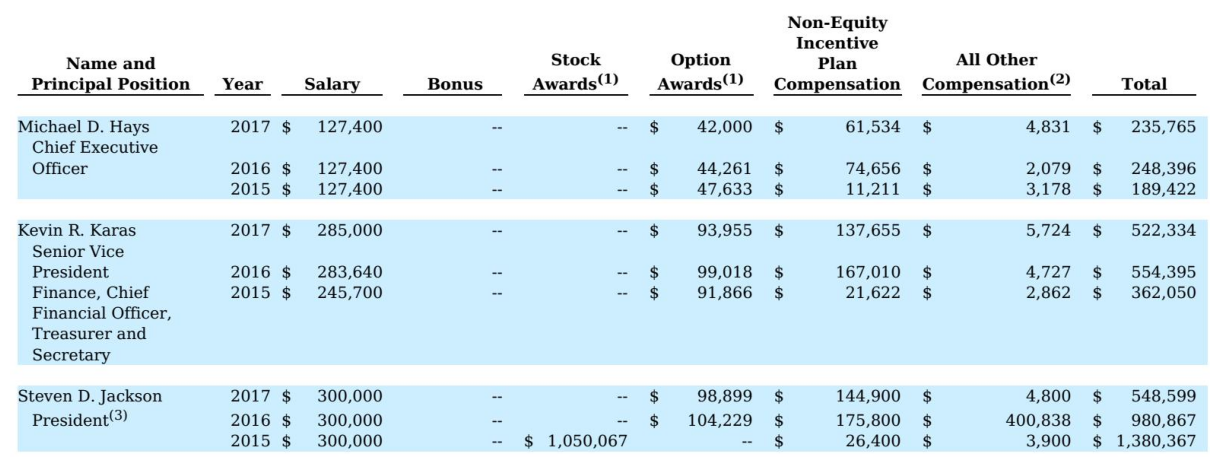


--- Table 5 (page 21) ---
Type: grants_plan_based_awards (0.95)

--- Table 6 (page 22) ---
Type: outstanding_equity (0.95)

--- Table 7 (page 23) ---
Type: option_exercises (0.95)

--- Table 8 (page 29) ---
Type: director_compensation (0.95)

--- Table 9 (page 30) ---
Type: other (0.95)

--- Table 10 (page 30) ---
Type: other (0.95)

--- Table 11 (page 31) ---
Type: other (0.95)

Found 1 Summary Compensation Tables


In [10]:
# Find summary compensation tables in a document
found = await find_summary_compensation_in_doc(
    doc_source=source_doc,
    all_tables=all_tables,
    client=client,
    model=MODEL,
    base_path=BASE_PATH,
    display_func=display,
    plt_module=plt,
    pil_image_class=PILImage
)

In [11]:
def merge_consecutive_tables(found: list[dict], images_base_dir: Path) -> list[dict]:
    """Merge tables split across pages."""
    if len(found) <= 1:
        return found
    
    merged = []
    skip_next = False
    
    for i, t in enumerate(found):
        if skip_next:
            skip_next = False
            continue
        
        # Check if should merge with next
        if i + 1 < len(found):
            t_next = found[i + 1]
            page_diff = t_next['table']['page_idx'] - t['table']['page_idx']
            same_doc = t['table']['source_doc'] == t_next['table']['source_doc']
            
            # Consecutive pages, same doc, first at bottom (y>500), second at top (y<150)
            if (page_diff == 1 and same_doc and 
                t['table']['bbox'][1] > 500 and 
                t_next['table']['bbox'][1] < 150):
                
                # Merge images
                img1 = Image.open(images_base_dir / t['table']['img_path'])
                img2 = Image.open(images_base_dir / t_next['table']['img_path'])
                
                max_w = max(img1.width, img2.width)
                combined = Image.new('RGB', (max_w, img1.height + img2.height), 'white')
                combined.paste(img1, (0, 0))
                combined.paste(img2, (0, img1.height))
                
                # Save merged image
                merged_name = f"merged_{i}.jpg"
                combined.save(images_base_dir / merged_name)
                
                # Create merged entry
                merged_t = t.copy()
                merged_t['table'] = t['table'].copy()
                merged_t['table']['img_path'] = merged_name
                merged_t['table']['table_body'] = t['table']['table_body'].replace('</table>', '') + t_next['table']['table_body'].replace('<table>', '')
                merged_t['merged'] = True  # Flag for extraction to use image
                
                merged.append(merged_t)
                skip_next = True
                print(f"📎 Merged tables {i} and {i+1} (pages {t['table']['page_idx']} + {t_next['table']['page_idx']})")
                continue
        
        merged.append(t)
    
    return merged


source_doc = found[0]['table']['source_doc']
# MinerU crea struttura annidata: output/doc_source/doc_source/vlm/
images_base_dir = Path(f"output/{source_doc}/{source_doc}/vlm")

found = merge_consecutive_tables(found, images_base_dir)

In [12]:
extracted = await extract_all_summary_compensation(
    found_tables=found,
    all_tables=all_tables,
    client=client,
    model=MODEL,
    base_path=BASE_PATH,
    metadata=meta
)

# Show first extracted table
if extracted:
    print(extracted[0].model_dump_json(indent=2))

✓ Extracted table 4: 9 executives
{
  "company": "NATIONAL RESEARCH CORP",
  "cik": "70487",
  "fiscal_year_end": "2018",
  "currency": "USD",
  "executives": [
    {
      "name": "Michael D. Hays",
      "title": "Chief Executive Officer",
      "fiscal_year": 2017,
      "salary": 127400.0,
      "bonus": 0.0,
      "stock_awards": 0.0,
      "option_awards": 42000.0,
      "non_equity_incentive": 61534.0,
      "change_in_pension": 0.0,
      "other_compensation": 4831.0,
      "total": 235765.0
    },
    {
      "name": "Michael D. Hays",
      "title": "Chief Executive Officer",
      "fiscal_year": 2016,
      "salary": 127400.0,
      "bonus": 0.0,
      "stock_awards": 0.0,
      "option_awards": 44261.0,
      "non_equity_incentive": 74656.0,
      "change_in_pension": 0.0,
      "other_compensation": 2079.0,
      "total": 248396.0
    },
    {
      "name": "Michael D. Hays",
      "title": "Chief Executive Officer",
      "fiscal_year": 2015,
      "salary": 127400.0,
   

In [ ]:
# Vediamo il table_body della tabella KB HOME
print(found[0]['table']['table_body'])

<table><tr><td rowspan="2"></td><td colspan="5">Annual Compensation</td></tr><tr><td>Year</td><td>Salary</td><td>Bonus</td><td>Other Annual Compensation</td><td>All Other Compensation(2)</td></tr><tr><td>&lt;S&gt;</td><td>&lt;C&gt;</td><td>&lt;C&gt;</td><td>&lt;C&gt;</td><td>&lt;C&gt;</td><td>&lt;C&gt;</td></tr><tr><td rowspan="3">Steven A. Rosso</td><td>2004</td><td>$198,083</td><td>$ 20,000</td><td>(1)</td><td>$ 4,927</td></tr><tr><td>2003</td><td>$174,750</td><td>$ -0-</td><td>(1)</td><td>$ 16,830</td></tr><tr><td>2002</td><td>$162,203</td><td>$ 9,333</td><td>(1)</td><td>$ 8,343</td></tr><tr><td>&lt;C&gt;</td><td>&lt;C&gt;</td><td>&lt;C&gt;</td><td>&lt;C&gt;</td><td>&lt;C&gt;</td></tr><tr><td>Gary A. Stewart</td><td>2004</td><td>$132,500</td><td>$ 10,000</td><td>(1)</td></tr><tr><td></td><td>2003</td><td>$117,500</td><td>$ 1,000</td><td>(1)</td></tr><tr><td></td><td>2002</td><td>$114,179</td><td>$ -0-</td><td>(1)</td></tr></table>
